In [199]:
import numpy as np
import pandas as pd
import scipy.io
import os
from scipy.signal import savgol_filter
from dtaidistance import dtw
import seaborn as sns
from sklearn import preprocessing
from numpy import inf
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from matplotlib import pyplot as plt
import scipy.spatial.distance as ssd

In [200]:
#load_path = 'D:\EECE499\Features\\'
load_path = '..\..\..\\'

In [201]:
Features = pd.read_excel(load_path + 'Features.xlsx')

In [202]:
Ratings = pd.read_excel(load_path + 'Ratings.xlsx')

In [203]:
presentations_ids = Features['presentation_id'].values
presentations_ids.shape

(603,)

In [204]:
indices_dict = []
series_gsr = []
series_neuro_sky = []
series_attention = []
series_meditation = []
series_alpha = []
series_beta = []
series_delta = []
series_gamma = []
series_theta = []

for i, presentation_id in enumerate(presentations_ids):
    print(presentation_id, end='\r')
    
    indices_dict.append(presentation_id)
    
    clip_id = presentation_id % 100
    user_id = int(presentation_id / 100)
    
    #data_path = './../../ASCERTAIN_Raw/GSRData/Movie_P' + str(user_id).zfill(2) + '/GSR_Clip' + str(clip_id) + '.mat'
    data_path = 'D:/EECE499/Raw/MyECGFunc/ASCERTAIN_Raw/GSRData/Movie_P' + str(user_id).zfill(2) + '/GSR_Clip' + str(clip_id) + '.mat'
    
    if os.path.isfile(data_path):
        
        signal = scipy.io.loadmat(data_path)
        resistance = signal['Data_GSR'][:,4]
        
        resistance = savgol_filter(resistance, 501, 3)
        series_gsr.append(resistance)
    
    data_path = 'D:/EECE499/Raw/MyECGFunc/ASCERTAIN_Raw/EEGData/Movie_P' + str(user_id).zfill(2) + '/EEG_Clip' + str(clip_id) + '.mat'
    
    if os.path.isfile(data_path):
        
        signal = scipy.io.loadmat(data_path)
        
        neuro_sky_EEG_raw = np.array(signal['ThisEEG'][0])
        attention_raw = np.array(signal['ThisEEG'][1])
        meditation_raw = np.array(signal['ThisEEG'][2])
        alpha_raw = np.array(signal['ThisEEG'][3])
        beta_raw = np.array(signal['ThisEEG'][4])
        delta_raw = np.array(signal['ThisEEG'][5])
        gamma_raw = np.array(signal['ThisEEG'][6])
        theta_raw = np.array(signal['ThisEEG'][7])
        
        window = 51 #101
        order = 4 #3
        try:
            neuro_sky_EEG_raw = savgol_filter(neuro_sky_EEG_raw, window, order)
            attention_raw = savgol_filter(attention_raw, window, order)
            meditation_raw = savgol_filter(meditation_raw, window, order)
            alpha_raw = savgol_filter(alpha_raw, window, order)
            beta_raw = savgol_filter(beta_raw, window, order)
            delta_raw = savgol_filter(delta_raw, window, order)
            gamma_raw = savgol_filter(gamma_raw, window, order)
            theta_raw = savgol_filter(theta_raw, window, order)
        except:
            l = len(neuro_sky_EEG_raw)
            neuro_sky_EEG_raw = np.zeros(l)
            attention_raw = np.zeros(l)
            meditation_raw = np.zeros(l)
            alpha_raw = np.zeros(l)
            beta_raw = np.zeros(l)
            delta_raw = np.zeros(l)
            gamma_raw = np.zeros(l)
            theta_raw = np.zeros(l)
        
        series_neuro_sky.append(neuro_sky_EEG_raw)
        series_attention.append(attention_raw)
        series_meditation.append(meditation_raw)
        series_alpha.append(alpha_raw)
        series_beta.append(beta_raw)
        series_delta.append(delta_raw)
        series_gamma.append(gamma_raw)
        series_theta.append(theta_raw)

In [205]:
dm_gsr = np.load('dist_matrix.npy')
dm_attention = np.load('dm_attention.npy')
dm_neuro_sky = np.load('dm_neuro_sky.npy')
dm_meditation = np.load('dm_meditation.npy')
dm_alpha = np.load('dm_alpha.npy')
dm_beta = np.load('dm_beta.npy')
dm_delta = np.load('dm_delta.npy')
dm_gamma = np.load('dm_gamma.npy')
dm_theta = np.load('dm_theta.npy')

In [206]:
def reformat_matrix(dm):
    i_lower = np.tril_indices(dm.shape[0], -1)
    dm[i_lower] = dm.T[i_lower]
    np.fill_diagonal(dm, 0)
    return dm

In [207]:
dm_gsr = reformat_matrix(dm_gsr)
dm_attention = reformat_matrix(dm_attention)
dm_neuro_sky = reformat_matrix(dm_neuro_sky)
dm_meditation = reformat_matrix(dm_meditation)
dm_alpha = reformat_matrix(dm_alpha)
dm_beta = reformat_matrix(dm_beta)
dm_delta = reformat_matrix(dm_delta)
dm_gamma = reformat_matrix(dm_gamma)
dm_theta = reformat_matrix(dm_theta)

In [208]:
dist_matrix = dm_gsr #+ dm_attention + dm_neuro_sky + dm_meditation + dm_alpha + dm_beta + dm_delta + dm_gamma + dm_theta
#dist_matrix = dm_neuro_sky

In [209]:
dist_array = ssd.squareform(dist_matrix)

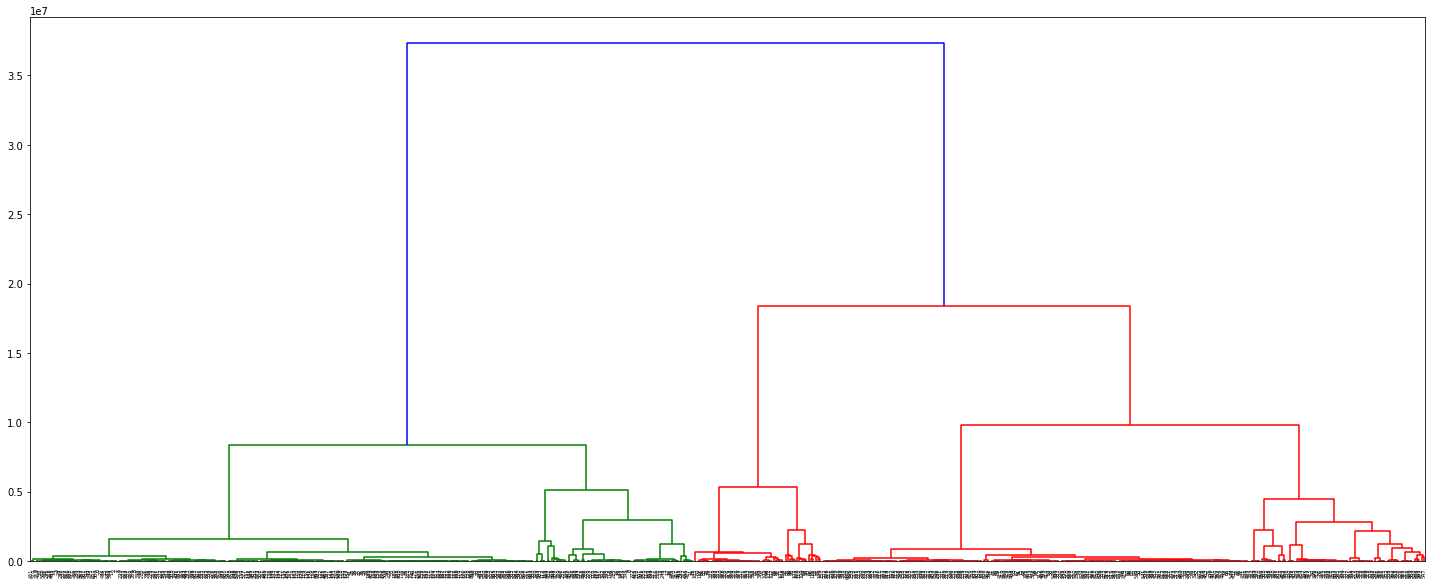

In [248]:
Z = linkage(dist_array, method='ward')

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z[:])
#plt.savefig('dendrogram_no_penalty.png', format='png', dpi=1000)
plt.show()

In [211]:
n = 7

tree = cut_tree(Z, n_clusters=n)
cutree = tree.T[0]

clusters = [[] for i in range(n)]
for i, c in enumerate(cutree):
    #print(i, c)
    clusters[c].append(indices_dict[i])

for i in range(n-1):
    print(len(clusters[i]) == sum(cutree == i))

True
True
True
True
True
True


In [212]:
arousal_clusters = [[] for i in range(n)]
engaging_clusters = [[] for i in range(n)]
familiarity_clusters = [[] for i in range(n)]
liking_clusters = [[] for i in range(n)]
valence_clusters = [[] for i in range(n)]

all_clusters = [arousal_clusters, engaging_clusters, familiarity_clusters, liking_clusters, valence_clusters]

In [213]:
def get_values(dimension, cluster):
    v = []
    for c in cluster:
        #print(Ratings.iloc[(Ratings.presentation_id == c).values][dimension].values[0])
        v.append(int(Ratings.iloc[(Ratings.presentation_id == c).values][dimension].values[0]))
        
        #v.append(int(c / 100))
    return v

In [214]:
for i in range(n):
    arousal_clusters[i] = get_values('arousal', clusters[i])
    engaging_clusters[i] = get_values('engaging', clusters[i])
    familiarity_clusters[i] = get_values('familiarity', clusters[i])
    liking_clusters[i] = get_values('liking', clusters[i])
    valence_clusters[i] = get_values('valence', clusters[i])

In [215]:
for cl in all_clusters:
    print("CLUSTER__________________")
    for c in cl:
        print(c)

CLUSTER__________________
[4, 3, 4, 3, 4, 2, 6, 3, 1, 4, 3, 5, 5, 4, 3, 3, 5, 4, 3, 3, 3, 5, 2, 5, 5, 2, 4, 4, 2, 4, 3, 4, 6, 4, 5, 5, 6, 5, 5, 6, 6, 5, 6, 4, 4, 3, 2, 6, 4, 3, 5, 3, 4, 5, 5, 6, 5, 2, 3, 4, 1, 4, 6, 4, 5, 5, 4, 4, 6, 4, 6, 5, 6, 6, 4, 6, 1, 4, 3, 5, 5, 4, 5, 4, 4, 3, 4, 5, 5, 2, 6, 4, 5, 6, 2, 3, 6, 6, 6, 6, 5, 5, 5, 6, 0, 5, 5, 4, 5, 5, 5, 6, 3, 4, 5, 4, 4, 2, 2, 4, 4, 3, 5, 3, 5, 5, 6, 5, 4, 3, 5, 4, 4, 4, 6, 5, 4, 4, 6, 5, 6, 5, 4, 4, 3, 4, 1, 5, 3, 1, 5, 1, 1, 3, 4, 4, 5, 5, 5, 4, 5, 4, 3, 4, 5, 5, 4, 6, 5, 4, 3, 6, 5, 3, 5, 4, 5, 6, 6, 5, 5, 6, 5, 6, 5, 5, 5, 1, 1, 4, 4, 3, 1, 5, 6, 4, 4, 5, 5, 2, 1, 4, 4, 4, 5, 5, 4, 5, 2, 1, 5, 5, 3, 5, 4, 5, 2, 3]
[4, 2, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4, 4, 5, 3, 5, 4, 4, 2, 3, 4, 2, 3, 5, 5, 5, 4, 5, 4, 2, 3, 3, 3, 2, 2, 3, 4, 4, 1, 3, 4, 5, 6, 1, 2, 4, 1, 3, 4, 2, 4, 3, 2, 3, 5]
[3, 3, 3, 3, 4, 3, 5, 4, 4, 5, 3, 3, 4, 3, 3, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 5, 3, 3, 5, 5, 4, 3, 4, 0, 4, 4, 3, 3, 4, 4, 3, 1, 3, 3,

In [234]:
def get_total(cluster):
    total_dict = {}
    for c in cluster:
        for v in c:
            try:
                total_dict[v] += 1
            except:
                total_dict[v] = 0
    return total_dict

def get_percent(cluster):
    total_dict = get_total(cluster)
    values = total_dict.keys()
    
    percent_dict = {}
    
    for i, c in enumerate(cluster):
        percent_dict['cluster_' + str(i)] = {}
        for v in values:
            percent_dict['cluster_' + str(i)][v] = (c.count(v) * 100 / total_dict[v])
    
    return percent_dict

In [237]:
dict_1 = get_percent(arousal_clusters)

In [241]:
arousal_clusters[0].count(0)

1

In [238]:
dict_1

{'cluster_0': {4: 30.0,
  3: 26.785714285714285,
  2: 20.967741935483872,
  6: 62.264150943396224,
  1: 41.37931034482759,
  5: 51.492537313432834,
  0: 16.666666666666668},
 'cluster_1': {4: 9.0,
  3: 14.285714285714286,
  2: 14.516129032258064,
  6: 1.8867924528301887,
  1: 10.344827586206897,
  5: 5.970149253731344,
  0: 0.0},
 'cluster_2': {4: 33.0,
  3: 37.5,
  2: 53.225806451612904,
  6: 11.320754716981131,
  1: 34.48275862068966,
  5: 17.16417910447761,
  0: 83.33333333333333},
 'cluster_3': {4: 16.5,
  3: 13.392857142857142,
  2: 8.064516129032258,
  6: 3.7735849056603774,
  1: 13.793103448275861,
  5: 12.686567164179104,
  0: 0.0},
 'cluster_4': {4: 8.0,
  3: 8.035714285714286,
  2: 3.225806451612903,
  6: 5.660377358490566,
  1: 0.0,
  5: 6.7164179104477615,
  0: 0.0},
 'cluster_5': {4: 2.5,
  3: 0.8928571428571429,
  2: 1.6129032258064515,
  6: 9.433962264150944,
  1: 0.0,
  5: 2.985074626865672,
  0: 0.0},
 'cluster_6': {4: 1.5,
  3: 0.0,
  2: 0.0,
  6: 7.547169811320755,
 

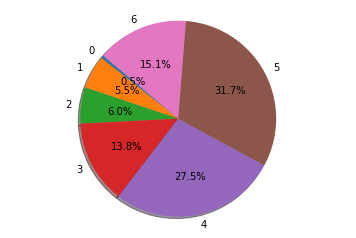

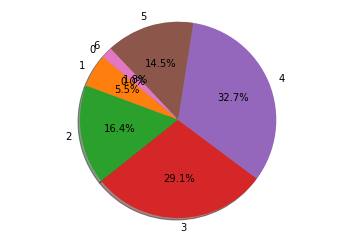

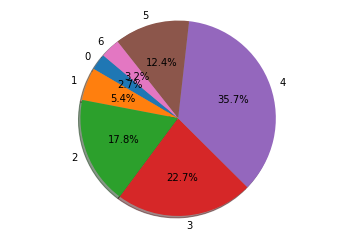

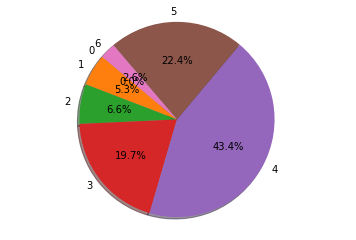

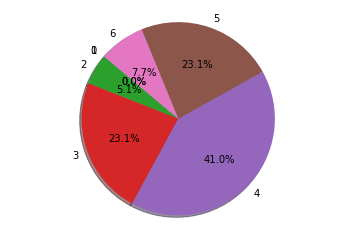

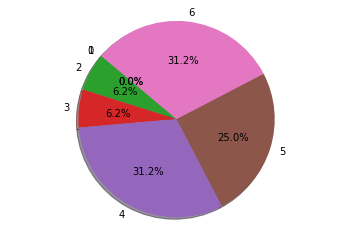

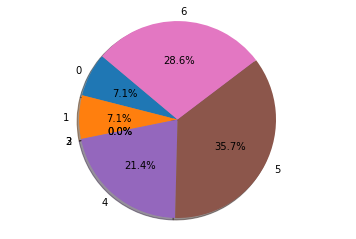

In [244]:
for a in arousal_clusters:
    # Data to plot
    labels = '0', '1', '2', '3', '4', '5', '6'
    sizes = [a.count(i) for i in range(7)]
    #colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    #explode = (0.1, 0, 0, 0)  # explode 1st slice

    # Plot
    plt.pie(sizes, labels=labels, #colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')
    plt.show()

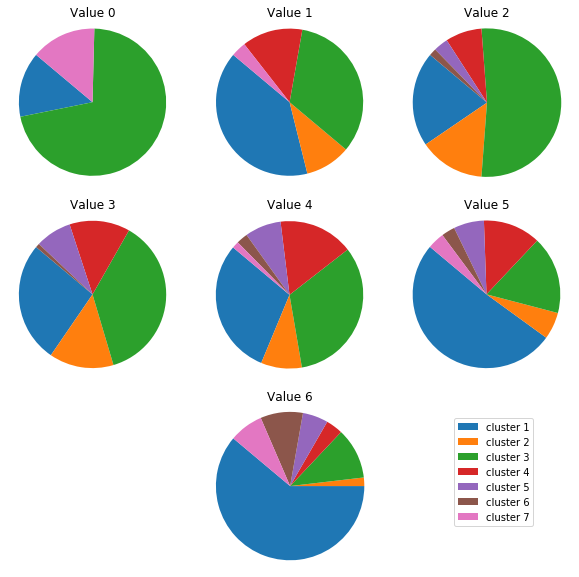

In [314]:
## Data to plot
#labels = '0', '', '2', '', '', '', '6'
#sizes = [a.count(0) for a in arousal_clusters]
##colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
##explode = (0.1, 0, 0, 0)  # explode 1st slice
#
## Plot
#plt.subplot(2,3,1)
#
#plt.title('Cluster 1')
#plt.pie(sizes, labels=labels, startangle=140)
#plt.axis('equal')
#
#
## Data to plot
#labels = '0', '', '2', '', '', '', '6'
#sizes = [a.count(1) for a in arousal_clusters]
##colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
##explode = (0.1, 0, 0, 0)  # explode 1st slice
#
## Plot
#plt.subplot(2,3,2)
#
#plt.title('Cluster 2')
#plt.pie(sizes, labels=labels, startangle=140)
#plt.axis('equal')

plt.rcParams["figure.figsize"] = (10,10)

for i in range(6):
    # Data to plot
    labels = '', '', '', '', '', '', ''
    sizes = [a.count(i) for a in arousal_clusters]
    #colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    #explode = (0.1, 0, 0, 0)  # explode 1st slice

    # Plot
    plt.subplot(3,3,i + 1)

    plt.title('Value ' + str(i))
    plt.pie(sizes, labels=labels, startangle=140)
    plt.axis('equal')

# Data to plot
labels = '', '', '', '', '', '', ''
sizes = [a.count(6) for a in arousal_clusters]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.subplot(3,3,8)

plt.title('Value ' + str(6))
plt.pie(sizes, labels=labels, startangle=140)
plt.axis('equal')

#plt.subplot(3,3,9)
plt.legend(['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5', 'cluster 6', 'cluster 7'], loc=(1.5,0.25))

plt.savefig('arousal_pie.png', format='png', dpi=1000)
plt.show()

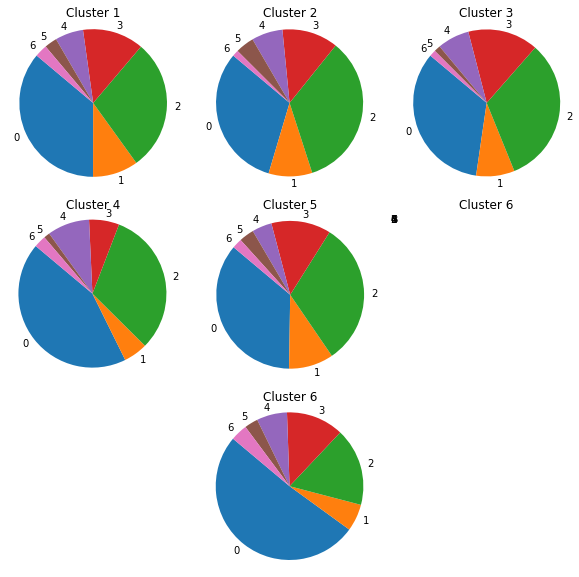

In [288]:
plt.rcParams["figure.figsize"] = (10,10)

for i in range(7):
    # Data to plot
    labels = '0', '1', '2', '3', '4', '5', '6'
    sizes = [a.count(i) for a in familiarity_clusters]
    #colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    #explode = (0.1, 0, 0, 0)  # explode 1st slice

    # Plot
    plt.subplot(3,3,i + 1)

    plt.title('Cluster ' + str(i+1))
    plt.pie(sizes, labels=labels, startangle=140)
    plt.axis('equal')

# Data to plot
labels = '0', '1', '2', '3', '4', '5', '6'
sizes = [a.count(i) for a in arousal_clusters]
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.subplot(3,3,8)

plt.title('Cluster ' + str(i+1))
plt.pie(sizes, labels=labels, startangle=140)
plt.axis('equal')


#plt.savefig('engaging_pie.png', format='png', dpi=1000)
plt.show()